In [12]:
# settings for tutorial presentation with RISE
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'width': '100%',
              'height': '100%',
              'scroll': True,
              'enable_chalkboard': False,
})

{'width': '100%', 'height': '100%', 'scroll': True, 'enable_chalkboard': False}

In [13]:
import gensim.downloader
import gensim
import pandas as pd
import numpy as np
import random
import torch
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
import datasets
import matplotlib.pyplot as plt
# enabling inline plots in Jupyter
%matplotlib inline
datasets.logging.set_verbosity_error()

# ASDS 2

# Tutorial: Word embeddings

Clara Vandeweerdt (based on work by Anna Rogers)

# 1. Playing with word embeddings

[Gensim](https://radimrehurek.com/gensim/) is a popular library for working with static word embeddings.

In [14]:
# see which embeddings are available for download
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [15]:
# download one pre-trained model
glove_twitter_25 = gensim.downloader.load('glove-twitter-25')

Note: These embedding files are loaded as [Keyed Vectors](https://radimrehurek.com/gensim/models/keyedvectors.html), and this is different from the [models](https://radimrehurek.com/gensim/models/word2vec.html) used for training your own embeddings. Most methods shown here are also available for the models, but the syntax might differ.

In [16]:
# retrieve the embedding matrix
glove_twitter_25.vectors[:3]

array([[ 0.62415 ,  0.62476 , -0.082335,  0.20101 , -0.13741 , -0.11431 ,
         0.77909 ,  2.6356  , -0.46351 ,  0.57465 , -0.024888, -0.015466,
        -2.9696  , -0.49876 ,  0.095034, -0.94879 , -0.017336, -0.86349 ,
        -1.3348  ,  0.046811,  0.36999 , -0.57663 , -0.48469 ,  0.40078 ,
         0.75345 ],
       [ 0.69586 , -1.1469  , -0.41797 , -0.022311, -0.023801,  0.82358 ,
         1.2228  ,  1.741   , -0.90979 ,  1.3725  ,  0.1153  , -0.63906 ,
        -3.2252  ,  0.61269 ,  0.33544 , -0.57058 , -0.50861 , -0.16575 ,
        -0.98153 , -0.8213  ,  0.24333 , -0.14482 , -0.67877 ,  0.7061  ,
         0.40833 ],
       [ 1.1242  ,  0.054519, -0.037362,  0.10046 ,  0.11923 , -0.30009 ,
         1.0938  ,  2.537   , -0.072802,  1.0491  ,  1.0931  ,  0.066084,
        -2.7036  , -0.14391 , -0.22031 , -0.99347 , -0.65072 , -0.030948,
        -1.0817  , -0.64701 ,  0.32341 , -0.41612 , -0.5268  , -0.047166,
         0.71549 ]], dtype=float32)

In [17]:
# retrieving the vector for a given word
glove_twitter_25["cat"]

array([-0.96419 , -0.60978 ,  0.67449 ,  0.35113 ,  0.41317 , -0.21241 ,
        1.3796  ,  0.12854 ,  0.31567 ,  0.66325 ,  0.3391  , -0.18934 ,
       -3.325   , -1.1491  , -0.4129  ,  0.2195  ,  0.8706  , -0.50616 ,
       -0.12781 , -0.066965,  0.065761,  0.43927 ,  0.1758  , -0.56058 ,
        0.13529 ], dtype=float32)

In [18]:
# retrieving topn most similar words
glove_twitter_25.most_similar("cat", topn=5)

[('dog', 0.9590820074081421),
 ('monkey', 0.920357882976532),
 ('bear', 0.9143136739730835),
 ('pet', 0.9108031392097473),
 ('girl', 0.8880629539489746)]

In [19]:
# which word is the least similar to the others?
glove_twitter_25.doesnt_match("republican democrat liberal chocolate".split())

'chocolate'

In [20]:
# see the similarity score between certain words
glove_twitter_25.similarity("media", "dress")

0.3898266

In [21]:
# see the neighbor rank between certain words
glove_twitter_25.rank("cat", "girl")
# girl is the how-manieth closest word to cat?

5

# 2. T-SNE dimensionality reduction for visualizing word embeddings

T-SNE is a popular method for visualizing word embeddings by reducing their dimensionality down to 2 dimensions, which can be plotted on x and y axis. It is [implemented](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) in sklearn.

```python
from sklearn.manifold import TSNE
```

In [23]:
# Pick some words whose embeddings we want to see reduced to 2 dimensions
words = ["cat", "dog", "hamster", "parrot", "goldfish", "canary",
         "lion", "zebra", "elephant", "giraffe", "camel", "antelope",
         "tea", "coffee", "lemonade", "cocktail", "chai", "cappucino"]

word_vectors = glove_twitter_25[words]    
word_vectors.shape

(18, 25)

In [24]:
# Visualize a set of words using T-SNE decomposition
tsne = TSNE(2, random_state=0, perplexity=5)
reduced_vectors = tsne.fit_transform(word_vectors)
x_coords = reduced_vectors[:, 0]
y_coords = reduced_vectors[:, 1]

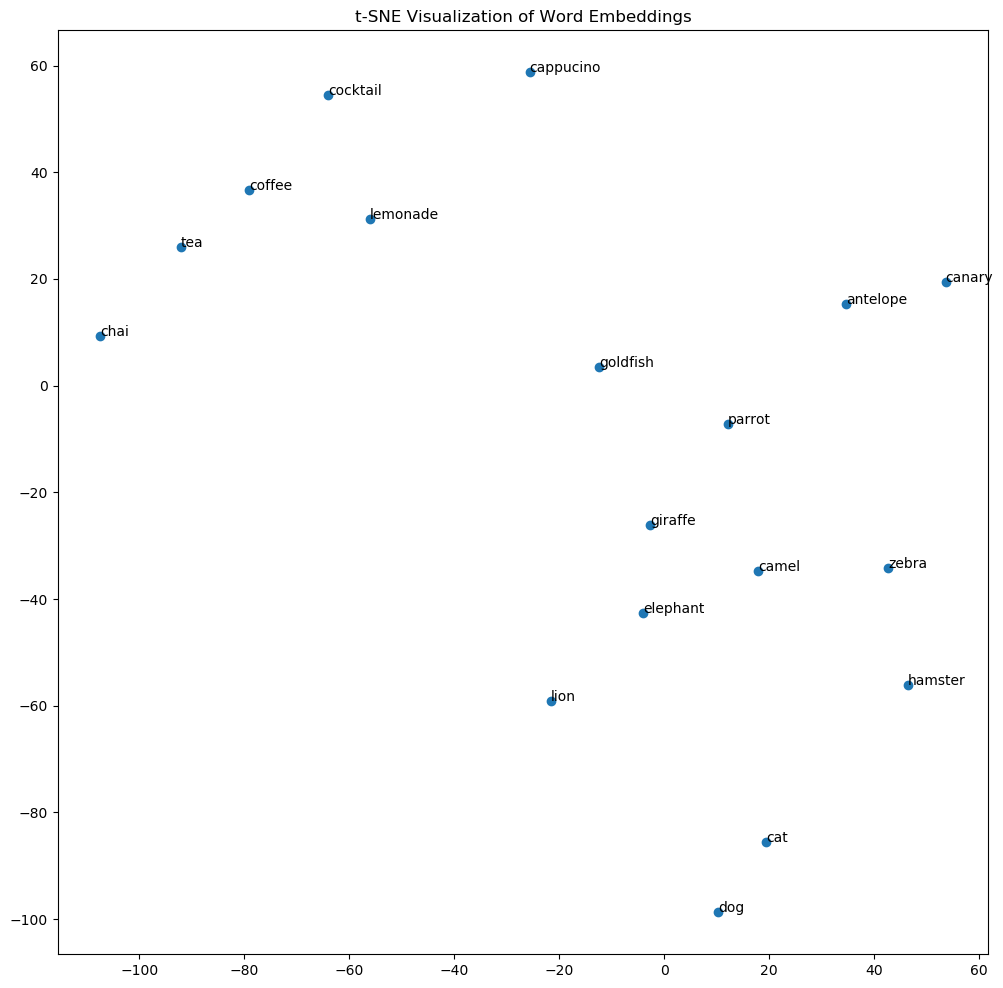

In [25]:
# Plot the embeddings
plt.figure(figsize=(12, 12))
plt.scatter(x_coords, y_coords)

# Add labels for each point
for i, word in enumerate(words):
    plt.annotate(word, (x_coords[i], y_coords[i]))

plt.title('t-SNE Visualization of Word Embeddings')
plt.show()

# 3. Training your own embeddings

Gensim provides implementations of several popular embedding methods, including [Word2vec](https://radimrehurek.com/gensim/models/word2vec.html) and [FastText](https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText).

First we will need to load our data. In the exercise we will use only very small corpora, but generally word embeddings are trained on large volumes of data that are impractical to load into memory at once. 

Let us practice with a custom data loader class that will read the data from disk line by line, and where we could add more pre-processing if we wished.

In [5]:
class MyDataLoader(object):

    # initialize the corpus object for a given filename
    def __init__(self, filename):
        self.corpus = filename

    # you will need to define how you want the next chunk of text (document, sentence etc)
    # to be provided. Here, we assume one line per document format.
    def __iter__(self):
        for line in open(self.corpus, "r"):
            # could do more preprocessing here
            line = line.split()
            yield line

We will experiment with the text of "Pride and prejudice" by Jane Austen. Let us load it:

In [6]:
pp = MyDataLoader("pp.txt")

In [7]:
# time to train the skip-gram model:
austen2vec = gensim.models.Word2Vec(
    pp,               # the corpus object we've loaded
    vector_size=50,  # the dimensionality of the target vectors
    window=2,         # window ngram size
    min_count=5,      # ignoring low-frequency words
    epochs=3,         # how many training passes to have
    sg = 1)           # 1 for skip-gram model, 0 for cbow

In [8]:
# the vectors now can be accessed through the .wv property of the model
austen2vec.wv.most_similar("Darcy")

[('Collins', 0.9846874475479126),
 ('Bingley', 0.9846115708351135),
 ('Darcy,', 0.9598349928855896),
 ('Gardiner', 0.9553936719894409),
 ('Bennet', 0.9501831531524658),
 ('Bennet,', 0.9481055736541748),
 ('Wickham', 0.9468832015991211),
 ('Collins,', 0.9441304802894592),
 ('Gardiner,', 0.9372818470001221),
 ("Darcy's", 0.9357696771621704)]

In [10]:
# the trained model can be saved to disk for future use
# see the gensim documentation for how to load local models of various types
austen2vec.save("pp.bin")

# Credits

* https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html